# Figures of theory-kernel-analysis project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

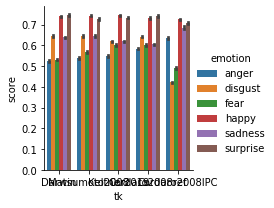

In [16]:
df = pd.read_csv('../results/theorykernel_scores.tsv', sep='\t', index_col=0)
sns.catplot(
    x='tk', y='score', hue='emotion', data=df, kind='bar', height=3
)